# ISTA 421 Final Project

> Henrik Swanberg

# 

## Purpose

This notebook implements and evaluates a multiple linear regression model to explain and predict trailing twelve-month revenue per available room (`ttm_revpar`) for Airbnb listings in Stockholm. Full context, research questions, and discussion are provided in the accompanying final report PDF. Each observation corresponds to a single Airbnb listing and contains both qualitative and quantitative features.

### Variables

- **Target (Quantitative):**
  - `ttm_revpar`: trailing twelve-month revenue per available room (SEK).

- **Predictors:**
  - `room_type` *(Qualitative)*
  - `beds` *(Quantitative)*
  - `ttm_avg_rate` *(Quantitative)*
  - `ttm_occupancy` *(Quantitative)*
  - `ttm_reserved_days` *(Quantitative)*
  - `ttm_available_days` *(Quantitative)*
  - `superhost` *(Qualitative/Binary)*



---

## Imports and setup

In [40]:
# imports for project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import scipy.stats as stats

## Data loading

In [41]:
# load full dataset
df = pd.read_csv('data/listings-data.csv')
df.shape

(300, 61)

## Dataset overview

Defining predictors and target from description.

In [42]:
# define target and features
target = "ttm_revpar"
feature_cols = [
    "room_type","beds",
    "ttm_avg_rate","ttm_occupancy",
    "ttm_reserved_days","ttm_available_days",
    "superhost"
]

# save as new dataframe
data = df[[target] + feature_cols].copy()
data.head()

,ttm_revpar,room_type,beds,ttm_avg_rate,ttm_occupancy,ttm_reserved_days,ttm_available_days,superhost
0,24.9,private_room,2.0,95.2,0.252,92,273,True
1,1.5,private_room,1.0,47.5,0.036,13,352,False
2,12.1,entire_home,2.0,123.6,0.099,36,329,False
3,31.7,private_room,1.0,83.3,0.356,130,235,True
4,62.0,entire_home,2.0,140.7,0.427,156,209,True


## Missing data handling
The dataset is checked for missing values and only a small number of rows have missing entries in the beds variable. These rows are removed, as the amount of missing data is limited and does not justify imputation.

In [43]:
data.isna().sum()

ttm_revpar            0
room_type             0
beds                  3
ttm_avg_rate          0
ttm_occupancy         0
ttm_reserved_days     0
ttm_available_days    0
superhost             0
dtype: int64

In [44]:
data = data.dropna() #drop rows with NaN
data.shape

(297, 8)

## Exploratory data analysis
As an exploratory check, I first examine the relationship between occupancy rate and revenue using a simple linear regression. This is used only to visualize directionality, noise, and residual patterns before fitting the full multiple linear regression model.

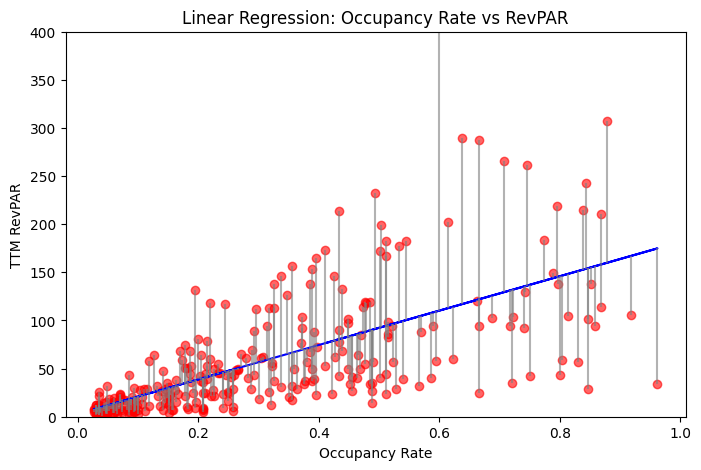

In [45]:
X = data[['ttm_occupancy']] # predictor
y = data['ttm_revpar'] # response

# exploratory simple regression for visualization
linreg = LinearRegression()
linreg.fit(X, y)

y_pred = linreg.predict(X)

plt.figure(figsize = (8, 5))
plt.scatter(X, y,
            color = 'red',
            alpha = 0.6)
plt.plot(X, y_pred,
            color = 'blue')
plt.vlines(X, y, y_pred,
            color = 'gray',
            alpha = 0.6)
plt.xlabel("Occupancy Rate")
plt.ylabel("TTM RevPAR")
plt.ylim(0, 400)
plt.title('Linear Regression: Occupancy Rate vs RevPAR')
plt.show()

OK! We plot the residuals:

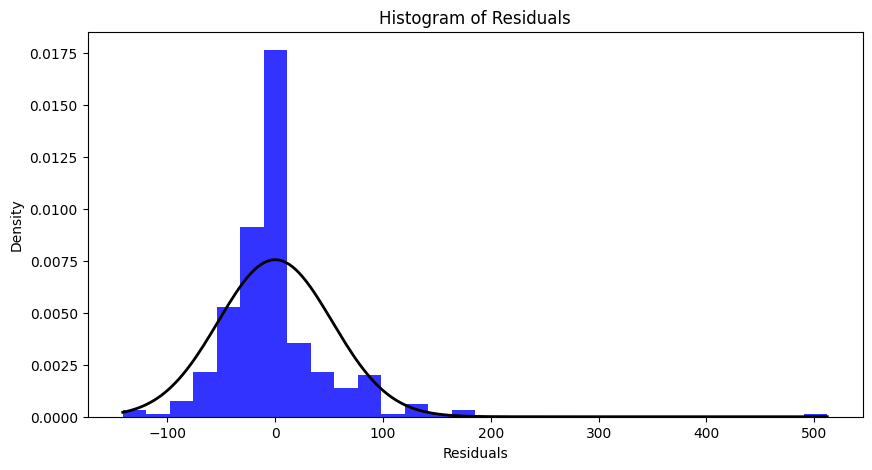

In [46]:
y_pred = linreg.predict(X)
resid = y - y_pred

plt.figure(figsize=(10, 5))
plt.hist(resid, bins=30, density=True, alpha=0.8, color='b')

mean_res = np.mean(resid)
std_res = np.std(resid)
x = np.linspace(resid.min(), resid.max(), 200)
plt.plot(x, stats.norm.pdf(x, mean_res, std_res), 'k', linewidth=2)

plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Density")
plt.show()

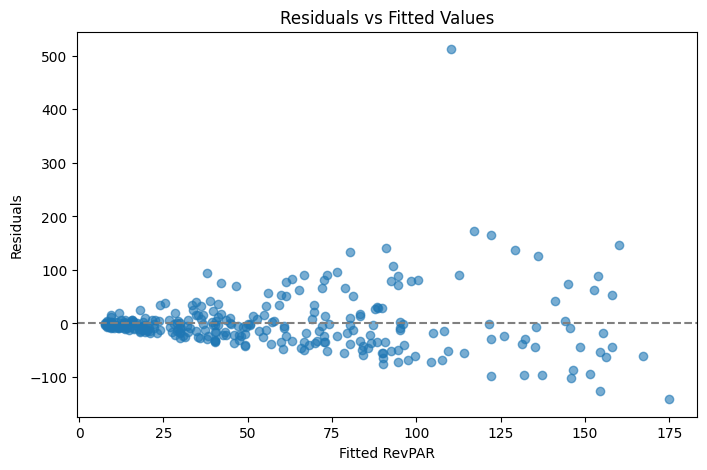

In [47]:
plt.figure(figsize=(8,5))
plt.scatter(y_pred, resid, alpha=0.6)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted RevPAR")
plt.ylabel("Residuals")
plt.show()

The residual plot suggests increasing variance at higher fitted values, indicating potential heteroscedasticity. This observation motivates further diagnostics after fitting the full multiple linear regression model.

## Preprocessing
Categorical variables are encoded to make them usable in regression. Superhost status is converted to a binary indicator, room type is one-hot encoded, and an interaction term between average rate and superhost status is created to test whether pricing effects differ for superhosts.

In [48]:
data["superhost"] = data["superhost"].astype(int)

data = pd.get_dummies(data, columns=["room_type"], drop_first=True, dtype=int)
data["ttm_avg_rate_x_superhost"] = data["ttm_avg_rate"] * data["superhost"]
data.head()

,ttm_revpar,beds,ttm_avg_rate,ttm_occupancy,ttm_reserved_days,ttm_available_days,superhost,room_type_private_room,room_type_shared_room,ttm_avg_rate_x_superhost
0,24.9,2.0,95.2,0.252,92,273,1,1,0,95.2
1,1.5,1.0,47.5,0.036,13,352,0,1,0,0.0
2,12.1,2.0,123.6,0.099,36,329,0,0,0,0.0
3,31.7,1.0,83.3,0.356,130,235,1,1,0,83.3
4,62.0,2.0,140.7,0.427,156,209,1,0,0,140.7


## Test train split
The data is split into training and test sets to evaluate how well the model generalizes to unseen listings.

In [49]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=["ttm_revpar"])
y = data["ttm_revpar"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=421)

print(f'training observations: {len(X_train)}')
print(f'test observations: {len(X_test)}')

training observations: 222
test observations: 75


## From scratch multiple linear regression (OLS)
This section implements multiple linear regression from scratch using ordinary least squares. The model is fit on the training set and evaluated on the held out test set. To measure the model's performance, I calculate R^2 and RMSE using $\text{RMSE} = \sqrt{\frac{1}{n}\sum (y_i - \hat{y}_i)^2}$. Higher R^2 and lower RMSE indicate better predictive accuracy.

In [57]:
# add a column of ones so the model has an intercept
X_train_m = np.column_stack((np.ones(len(X_train)), X_train.to_numpy()))

X_test_m = np.column_stack((np.ones(len(X_test)), X_test.to_numpy()))

# response variables
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

# solve OLS
beta_hat, residuals, rank, singular_vals = np.linalg.lstsq(X_train_m, y_train_np, rcond=None)

# pred. on train and test
yhat_train = X_train_m @ beta_hat
yhat_test = X_test_m @ beta_hat

# metrics (from scratch)
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def r2(y_true, y_pred):
    rss = np.sum((y_true - y_pred) ** 2)
    tss = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - rss / tss

print(f'Train R^2: {r2(y_train_np, yhat_train):.3f}')
print(f'Test R^2: {r2(y_test_np, yhat_test):.3f}')
print(f'Train RMSE: {rmse(y_train_np, yhat_train):.2f}')
print(f'Test RMSE: {rmse(y_test_np, yhat_test):.2f}')

Train R^2: 0.865
Test R^2: 0.762
Train RMSE: 25.23
Test RMSE: 30.69


The from scratch OLS model achieves strong performance on the training data and maintains good performance on the test set, suggesting reasonable generalization. RMSE is measured in SEK, making the typical prediction error directly interpretable.

## Model comparison
To check whether the interaction term actually helps, I compare a base model without the interaction to a model that includes avg rate × superhost. Both models are fit with the same train test split and evaluated on the same test set.

In [59]:
def fit_ols_and_predict(X_train_df, X_test_df, y_train_series):
    X_train_m = np.column_stack((np.ones(len(X_train_df)), X_train_df.to_numpy()))
    X_test_m = np.column_stack((np.ones(len(X_test_df)), X_test_df.to_numpy()))
    y_train_np_local = y_train_series.to_numpy()

    beta_hat_local, residuals, rank, singular_vals = np.linalg.lstsq( X_train_m, y_train_np_local, rcond=None)

    yhat_train_local = X_train_m @ beta_hat_local
    yhat_test_local = X_test_m @ beta_hat_local
    return beta_hat_local, yhat_train_local, yhat_test_local

# define feature sets
full_cols = list(X_train.columns)
base_cols = [c for c in full_cols if c != 'ttm_avg_rate_x_superhost']

# fit base model
beta_base, yhat_train_base, yhat_test_base = fit_ols_and_predict(X_train[base_cols], X_test[base_cols], y_train)

# fit full model
beta_full, yhat_train_full, yhat_test_full = fit_ols_and_predict(X_train[full_cols], X_test[full_cols], y_train)

print('Base model')
print(f'Test R^2:  {r2(y_test_np, yhat_test_base):.3f}')
print(f'Test RMSE: {rmse(y_test_np, yhat_test_base):.2f}')

print('\nFull model (with interaction)')
print(f'Test R^2:  {r2(y_test_np, yhat_test_full):.3f}')
print(f'Test RMSE: {rmse(y_test_np, yhat_test_full):.2f}')

Base model
Test R^2:  0.810
Test RMSE: 27.41

Full model (with interaction)
Test R^2:  0.762
Test RMSE: 30.69


Based on the test set results, the base model without the interaction term achieves higher R^2 and lower RMSE than the model including the average rate x superhost interaction. This indicates that the interaction does not improve out of sample performance and may add unnecessary complexity. For the remaining analysis and diagnostics, I therefore use the base model for simplicity and interpretability.

In [60]:
# refit base model to carry forward as final model
final_cols = base_cols

X_train_final = X_train[final_cols]
X_test_final = X_test[final_cols]

X_train_m = np.column_stack((np.ones(len(X_train_final)), X_train_final.to_numpy()))
X_test_m = np.column_stack((np.ones(len(X_test_final)), X_test_final.to_numpy()))

y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

final_beta, residuals, rank, singular_vals = np.linalg.lstsq(
    X_train_m, y_train_np, rcond=None
)

final_yhat_train = X_train_m @ final_beta
final_yhat_test = X_test_m @ final_beta

## Visual evaluation
I evaluate the predictive performance of the final model using a predicted versus actual plot on the test set. A well performing model should place points close to the 45 degree line.

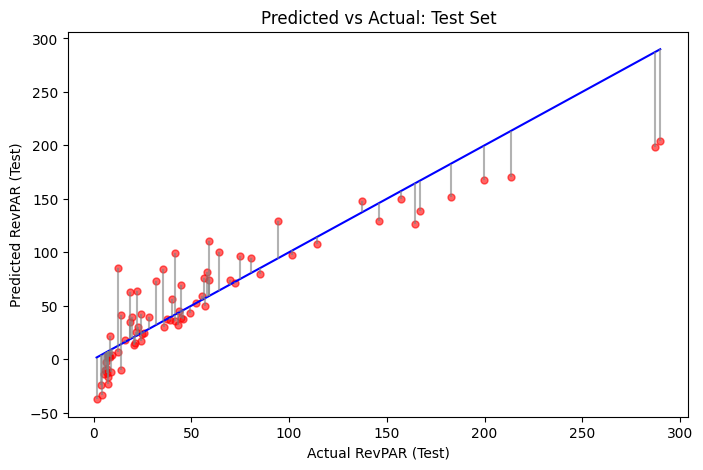

In [71]:
# predicted vs actual plot for final model (test set)
y_actual = y_test_np
y_pred = final_yhat_test

plt.figure(figsize=(8, 5), dpi=100)
plt.scatter(y_actual,y_pred,color='red',alpha=0.6, s=25)
plt.plot([y_actual.min(), y_actual.max()],[y_actual.min(), y_actual.max()],color='blue')
plt.vlines(y_actual,y_pred,y_actual,color='gray',alpha=0.6)

plt.xlabel('Actual RevPAR (Test)')
plt.ylabel('Predicted RevPAR (Test)')
plt.title('Predicted vs Actual: Test Set')
plt.show()

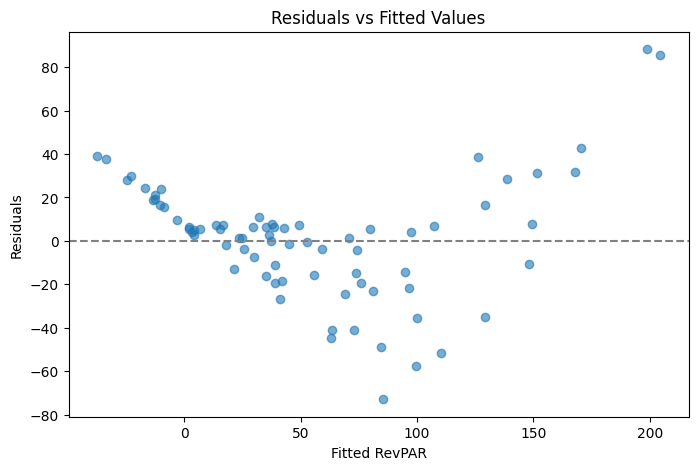

In [74]:
# residuals vs fitted values for final model (test set)
y_pred = final_yhat_test
resid = y_test_np - final_yhat_test

plt.figure(figsize=(8,5))
plt.scatter(y_pred, resid, alpha=0.6)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted RevPAR')
plt.ylabel('Residuals')
plt.show()

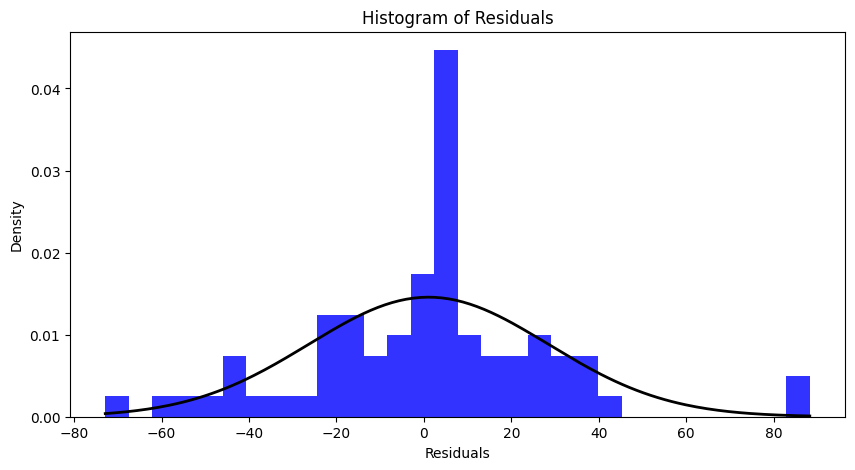

In [75]:
# histogram of residuals for final model (test set)
plt.figure(figsize=(10,5))
plt.hist(resid, bins=30, density=True, alpha=0.8, color='b')

mean_res = np.mean(resid)
std_res = np.std(resid)

x = np.linspace(resid.min(), resid.max(), 200)
plt.plot(x, stats.norm.pdf(x, mean_res, std_res), 'k', linewidth=2)

plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

The residuals are centered around zero but show a mild U-shaped pattern and increasing variance at higher fitted values. This suggests that the linear specification does not fully capture nonlinear revenue dynamics and that prediction uncertainty grows for higher-revenue listings. The residual distribution is approximately symmetric but exhibits heavier tails, indicating the presence of larger errors for a subset of listings. These patterns reflect limitations of an unconstrained linear model rather than implementation issues.

## Sklearn verification
As a verification step, I fit a linear regression model using sklearn on the same feature set and train–test split. This is used only to confirm that the from-scratch OLS implementation produces consistent predictions and evaluation metrics.

In [77]:
from sklearn.linear_model import LinearRegression

# fit sklearn linear regression using the same features
sk_model = LinearRegression()
sk_model.fit(X_train[final_cols], y_train)

# predictions on test set
sk_yhat_test = sk_model.predict(X_test[final_cols])

print(f'Sklearn test R^2:   {r2(y_test_np, sk_yhat_test):.3f}')
print(f'Sklearn test RMSE: {rmse(y_test_np, sk_yhat_test):.2f}')

Sklearn test R^2:   0.810
Sklearn test RMSE: 27.41


Sklearn results fully match the from-scratch OLS results, confirming the correctness of the manual implementation.

## Results and conclusions
The final multiple linear regression model achieves strong performance on the test set, indicating that it explains a substantial share of the variation in Airbnb revenue across listings. Demand- and pricing-related variables, such as occupancy rate and average daily rate, emerge as the most important drivers of revenue, while property characteristics and host status contribute additional but smaller effects once demand is controlled for. Diagnostic plots reveal increasing error variance and mild nonlinearity at higher revenue levels, suggesting that the linear specification is less precise for top-earning listings. Overall, the results answer the project question by identifying which listing characteristics most strongly relate to revenue differences in Stockholm Airbnb data, while also highlighting clear limitations of a simple linear model.

## Workforce preparation
This project strengthened skills in building a reproducible end-to-end analysis pipeline, implementing ordinary least squares using linear algebra, debugging data preprocessing and encoding issues, and evaluating models using both quantitative metrics and diagnostic plots. It also reinforced the ability to interpret model outputs critically and communicate limitations clearly, which is directly relevant for data-driven roles in consulting, finance, and analytics where model judgment and explanation matter as much as technical implementation.